In [2]:
#import zipfile as zf
#files = zf.ZipFile("tiny-imagenet-200.zip", 'r')
#files.extractall()
#files.close

<bound method ZipFile.close of <zipfile.ZipFile filename='tiny-imagenet-200.zip' mode='r'>>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torch.utils.data as data
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

import vgg
import resnet
import googlenet
import alexnet

In [2]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}

data_dir = 'tiny-imagenet-200/'

num_workers = {
    'train' : 100,
    'val'   : 0,
    'test'  : 0
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True,num_workers=num_workers[x])
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [ ]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

images, labels = next(iter(dataloaders['train']))
print(labels)
grid_img = make_grid(images[:4], nrow=4)
imshow(grid_img)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        
        
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        
        
        
        return x

net = alexnet.AlexNet()     # Create the network instance.
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [35]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(dataloaders['train'], 0):
        
        net.train()
        
        # Get the inputs
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 6.905
[epoch: 0, i:   199] avg mini-batch loss: 6.896
[epoch: 0, i:   299] avg mini-batch loss: 6.879
[epoch: 0, i:   399] avg mini-batch loss: 6.344
[epoch: 0, i:   499] avg mini-batch loss: 5.517
[epoch: 0, i:   599] avg mini-batch loss: 5.454
[epoch: 0, i:   699] avg mini-batch loss: 5.427
[epoch: 0, i:   799] avg mini-batch loss: 5.406
[epoch: 0, i:   899] avg mini-batch loss: 5.398
[epoch: 0, i:   999] avg mini-batch loss: 5.388
[epoch: 1, i:    99] avg mini-batch loss: 5.387
[epoch: 1, i:   199] avg mini-batch loss: 5.379
[epoch: 1, i:   299] avg mini-batch loss: 5.371
[epoch: 1, i:   399] avg mini-batch loss: 5.369
[epoch: 1, i:   499] avg mini-batch loss: 5.371
[epoch: 1, i:   599] avg mini-batch loss: 5.364
[epoch: 1, i:   699] avg mini-batch loss: 5.361
[epoch: 1, i:   799] avg mini-batch loss: 5.357
[epoch: 1, i:   899] avg mini-batch loss: 5.353
[epoch: 1, i:   999] avg mini-batch loss: 5.360
[epoch: 2, i:    99] avg mini-batch loss

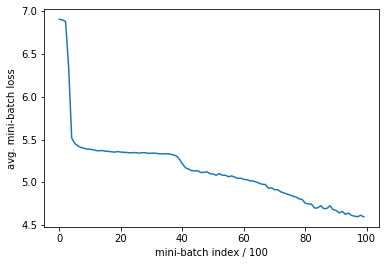

In [36]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [37]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        net.eval()
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 0 %
